In [ ]:
from yahoodownloader import YahooDownloader
from preprocessors import FeatureEngineer
from models import DRLEnsembleAgent
import numpy as np
import pandas as pd

In [48]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

In [49]:
# TecDAX constituents at 2021/02
TECDAX_TICKER = [
    "ADV.DE",
    "AFX.DE",
    "AM3D.DE",
    "BC8.DE",
    "COK.DE",
    "DLG.DE",
    "DRI.DE",
    "DRW3.DE",
    "EVT.DE",
    "FNTN.DE",
    "GFT.DE",
    "JEN.DE",
    "MDG1.DE",
    "MOR.DE",
    "NDX1.DE",
    "NEM.DE",
    "O2D.DE",
    "PFV.DE",
    "QIA.DE",
    "RIB.DE",
    "S92.DE",
    "SANT.DE",
    "SOW.DE",
    "SRT3.DE",
    "UTDI.DE",
    "WAF.DE",
    "WDI.DE",
]

# Dow-Jones constituents at 2021/02
DOW_30_TICKER = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW",
]

# DAX constituents at 2021/02
DAX_30_TICKER = [
    "DHER.DE",
    "RWE.DE",
    "FRE.DE",
    "MTX.DE",
    "MRK.DE",
    "LIN.DE",
    "ALV.DE",
    "VNA.DE",
    "EOAN.DE",
    "HEN3.DE",
    "DAI.DE",
    "DB1.DE",
    "DPW.DE",
    "DWNI.DE",
    "BMW.DE",
    "DTE.DE",
    "VOW3.DE",
    "MUV2.DE",
    "1COV.DE",
    "SAP.DE",
    "FME.DE",
    "BAS.DE",
    "BAYN.DE",
    "BEI.DE",
    "CON.DE",
    "SIE.DE",
    "ADS.DE",
    "HEI.DE",
    "DBK.DE",
    "IFX.DE",
]

In [51]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [52]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817787,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300190,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777557,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523605,7325600,CAT,0


In [53]:
INDICATORS = ["macd",
            "boll_ub",
            "boll_lb",
            "rsi_30",
            "cci_30",
            "dx_30",
            "close_30_sma",
            "close_60_sma",
        ]

In [54]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [55]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
2576,2010-05-11,29.809999,30.080000,29.549999,24.338903,9614100,UNH,1,-0.553362,43.609747,-77.041015,11.736397,0.000000
52323,2017-03-06,113.250000,113.500000,112.669998,84.914627,4731900,CVX,0,0.033312,52.752707,25.758245,1.516814,10.443633
22147,2013-01-15,26.830000,27.290001,26.830000,22.239416,48244500,MSFT,1,-0.088228,48.286417,37.726826,8.470751,30.472565
35480,2014-11-11,33.360001,33.540001,33.200001,25.898684,19676600,INTC,1,0.103050,50.812898,27.156662,14.474299,9.657687
56308,2017-09-19,62.996181,63.129772,62.671757,52.327702,7345746,MRK,1,0.739380,62.965176,142.875041,23.687492,33.538310


In [56]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [57]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [58]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)


In [59]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [60]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.71829873833732
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_8
----------------------------------------
| time/                 |              |
|    fps                | 267          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -41.1        |
|    explained_variance | 0.103        |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -43.6        |
|    reward             | -0.060437355 |
|    std                | 1            |
|    value_loss         | 1.81         |
----------------------------------------
--------------------------------------
| time/          

In [25]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,DDPG,0.192077,0.185683,0.225868
1,189,2022-01-03,2022-03-31,DDPG,-0.29392,-0.25255,-0.1418
2,252,2022-03-31,2022-06-30,PPO,-0.334913,-0.323758,-0.357652
3,315,2022-06-30,2022-09-27,DDPG,-0.461999,-0.205301,-0.131556


In [61]:
import torch
torch.save(ensemble_agent, 'ensemble_agent.pt')

In [62]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [63]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.739577055871337


In [64]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000932e+06,2022-01-04,0.000932,2022-01-04
2,9.974004e+05,2022-01-05,-0.003528,2022-01-05
3,9.954190e+05,2022-01-06,-0.001987,2022-01-06
4,9.951867e+05,2022-01-07,-0.000233,2022-01-07


<Axes: >

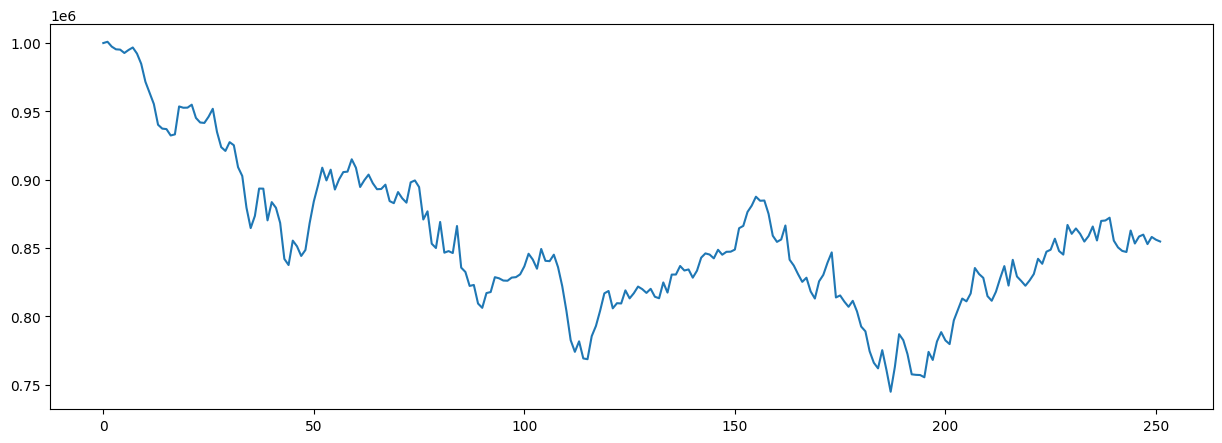

In [65]:
%matplotlib inline
df_account_value.account_value.plot()

In [31]:
from plot import backtest_stats, get_baseline
import datetime
import matplotlib.pyplot as plt

/Users/omgodage/Desktop/College/sem 5/CS337/CS-337-project-main/venv/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [66]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.145239
Cumulative returns    -0.145239
Annual volatility      0.188900
Sharpe ratio          -0.739577
Calmar ratio          -0.567536
Stability              0.400239
Max drawdown          -0.255912
Omega ratio            0.885277
Sortino ratio         -1.002960
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.128654
Daily value at risk   -0.024354
dtype: float64


In [67]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [68]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_ndx+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000932e+06
2022-01-05  9.974004e+05
2022-01-06  9.954190e+05
2022-01-07  9.951867e+05
...                  ...
2022-12-27  8.597843e+05
2022-12-28  8.528634e+05
2022-12-29  8.580895e+05
2022-12-30  8.560809e+05
2023-01-03  8.547608e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.000932e+06  1.005866e+06
2022-01-05  9.974004e+05  9.951360e+05
2022-01-06  9.954190e+05  9.904718e+05
2022-01-07  9.951867e+05  9.903404e+05
...       

<Figure size 1500x500 with 0 Axes>

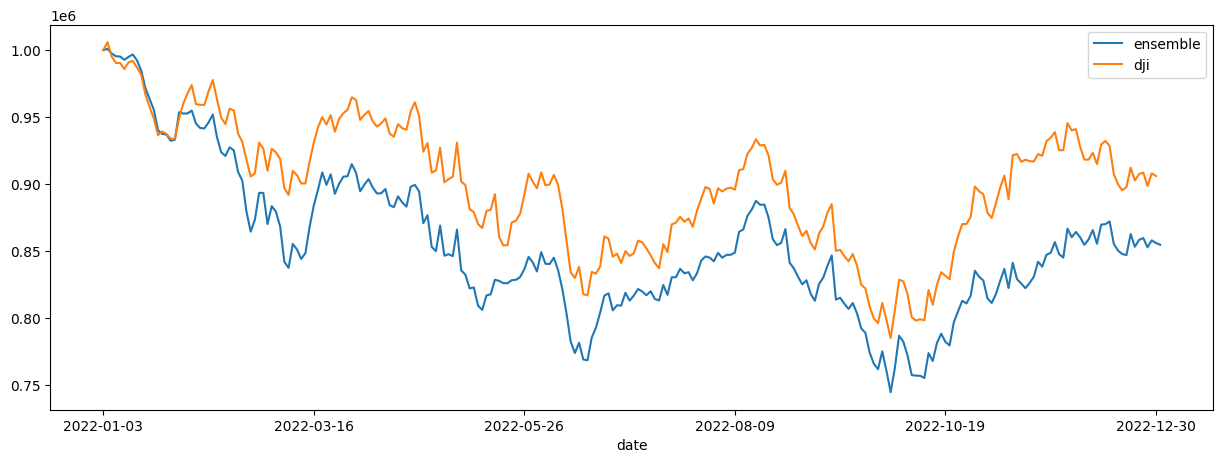

In [69]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)


print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();
plt.savefig("plot_dji.jpg")

# Individual Agents

============Start Ensemble Strategy============
turbulence_threshold:  201.71829873833732
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_11
======A2C Validation from:  2021-10-04 to  2022-01-03
A2C Sharpe Ratio:  0.2169690693684687
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_10
======PPO Validation from:  2021-10-04 to  2022-01-03
PPO Sharpe Ratio:  0.10456086074639126
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_126_10
day: 2957, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 5849102.28
total_reward: 4849102.28
total_cost: 999.00
total_trades: 50269
Sharpe: 0.912
----------------------------------
| time/              |

<Axes: >

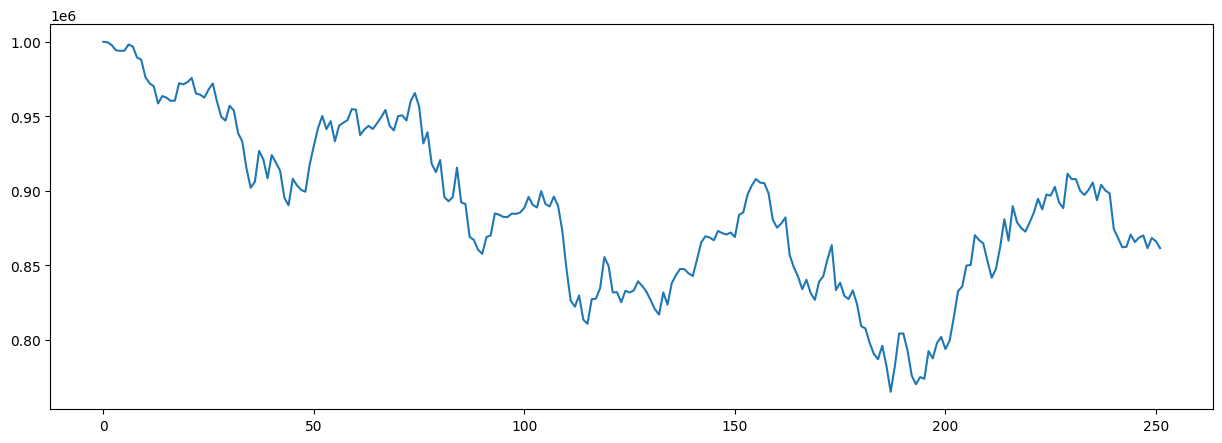

In [83]:
individual_agent = DRLEnsembleAgent(df=processed,
                    train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                    val_test_period=(TEST_START_DATE,TEST_END_DATE),
                    rebalance_window=rebalance_window, 
                    validation_window=validation_window, 
                    **env_kwargs)
A2C_dummy_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0
    # 'learning_rate': 0.0007
}

PPO_dummy_kwargs = {
    "ent_coef":0.01,
    "n_steps": 2048,
    # "learning_rate": 0.00025,
    "learning_rate": 0,
    "batch_size": 128
}

DDPG_dummy_kwargs = {
    #"action_noise":"ornstein_uhlenbeck",
    "buffer_size": 10_000,
    # "learning_rate": 0.0000,
    "learning_rate": 0.0005,
    "batch_size": 64
}

dummy_time_dict = {
    'a2c': 0,
    'ppo': 0,
    'ddpg': 10_000
}
single_summary = individual_agent.run_ensemble_strategy(A2C_dummy_kwargs, PPO_dummy_kwargs, DDPG_dummy_kwargs, dummy_time_dict)
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

df_account_value.head()

%matplotlib inline
df_account_value.account_value.plot()

df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]
df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  202

<Figure size 1500x500 with 0 Axes>

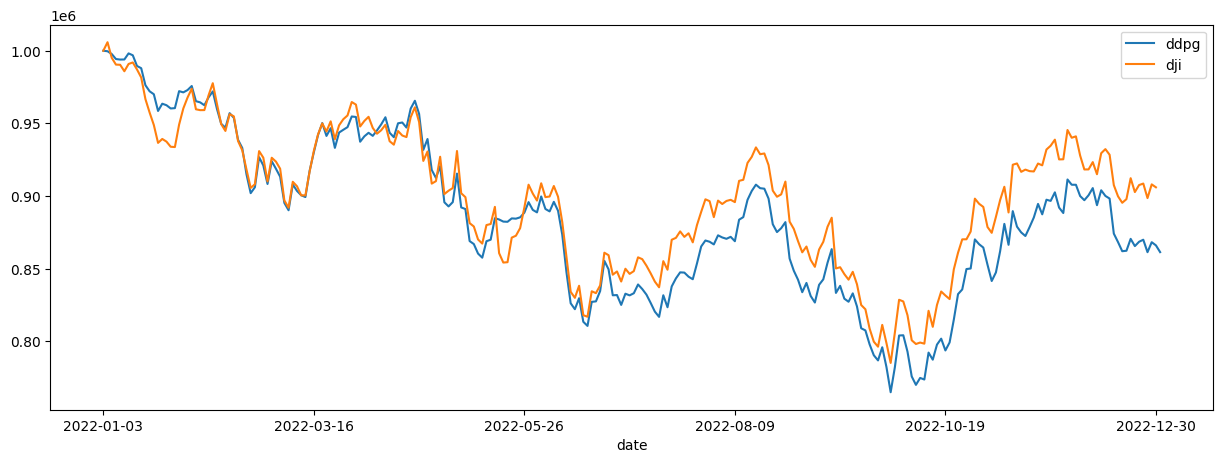

In [84]:

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_ndx.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_ndx+.csv")

df_account_value.to_csv('df_account_value.csv')

df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result_ddpg.csv")
result.columns = ['ddpg', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot()
plt.savefig("plot_ddpg_dji.jpg")